In [13]:
import pickle
from plot import plot_reducted_data, plot_error_vs_n_neighbors
from data_utils import load_datasets
from reduction_methods import find_optimal_n_neighbors

In [14]:
import importlib
import evaluator
import reduction_methods
import plot
import data_utils

# Recharger les modules
importlib.reload(evaluator)
importlib.reload(reduction_methods)
importlib.reload(plot)
importlib.reload(data_utils)

<module 'data_utils' from 'c:\\Users\\levovo pro p50\\Documents\\informatique\\MALIA\\manifold_learning\\projet Manifold-learning better\\data_utils.py'>

# The data for LLE and T-SNE

In [4]:
n_points = 300
datasets = load_datasets(n_points=n_points)
mnist_data, mnist_labels = datasets['Fashion MNIST']
swiss_roll_data, swiss_roll_labels = datasets['Hyper Swiss Roll']
double_helix_data, double_helix_labels = datasets['Double Helix']
sphere_data, sphere_labels = datasets['Partial Sphere']

# Selection de n_neighbors pour LLE et Isomap

On cherche le n_neighbors optimal vis a vis de la reconstruction error pour LLE et avec la geodesic error pour Isomap.

In [22]:
# !!! Ne pas compiler ça dure 1h30, les résultats sont sauvegardés dans optimal_n_neighbors_results.pkl compiler les cellules d'après pour plot les résultats.
# Recherche du n_neighbors optimal
n_neighbors_range = range(5, 41)
optimal_n_neighbors_results = find_optimal_n_neighbors(datasets, n_neighbors_range)

# Affichage des résultats
for dataset_name, result in optimal_n_neighbors_results.items():
    print(f"\nDataset: {dataset_name}")
    for method, details in result.items():
        if method == 'LLE':
            print(f"{method} - Optimal n_neighbors: {details['Optimal n_neighbors']}")
            print(f"Distance Correlation: {details.get('Distance Correlation')}")
        elif method == 'Isomap':
            print(f"{method} - Optimal n_neighbors: {details['Optimal n_neighbors']}")
            print(f"Geodesic Error: {details.get('Geodesic Error')}")

# Sauvegarde des résultats dans un pickle
with open('optimal_n_neighbors_results.pkl', 'wb') as f:
    pickle.dump(optimal_n_neighbors_results, f)

print("Dictionnaire sauvegardé avec succès dans 'optimal_n_neighbors_results.pkl'")


Processing dataset: Fashion MNIST
Optimal n_neighbors for LLE on Fashion MNIST: 40
Optimal n_neighbors for Isomap on Fashion MNIST: 40
Processing dataset: Hyper Swiss Roll
Optimal n_neighbors for LLE on Hyper Swiss Roll: 36
Optimal n_neighbors for Isomap on Hyper Swiss Roll: 40
Processing dataset: Double Helix
Optimal n_neighbors for LLE on Double Helix: 15
Optimal n_neighbors for Isomap on Double Helix: 40
Processing dataset: Partial Sphere
Optimal n_neighbors for LLE on Partial Sphere: 11
Optimal n_neighbors for Isomap on Partial Sphere: 40

Dataset: Fashion MNIST
LLE - Optimal n_neighbors: 40
Distance Correlation: [np.float64(0.5107), np.float64(0.3925), np.float64(0.3871), np.float64(0.4071), np.float64(0.4425), np.float64(0.4744), np.float64(0.4816), np.float64(0.4986), np.float64(0.5135), np.float64(0.5346), np.float64(0.5734), np.float64(0.5675), np.float64(0.5955), np.float64(0.6066), np.float64(0.6248), np.float64(0.6325), np.float64(0.6224), np.float64(0.592), np.float64(0.60

In [5]:

# Range of n_neighbors to test
if n_neighbors_range is None:
    n_neighbors_range = range(5, 41)

# Charger le dictionnaire depuis le fichier pickle
with open('optimal_n_neighbors_results.pkl', 'rb') as f:
    optimal_n_neighbors_results = pickle.load(f)

print("Dictionnaire chargé avec succès depuis 'optimal_n_neighbors_results.pkl'")

Dictionnaire chargé avec succès depuis 'optimal_n_neighbors_results.pkl'


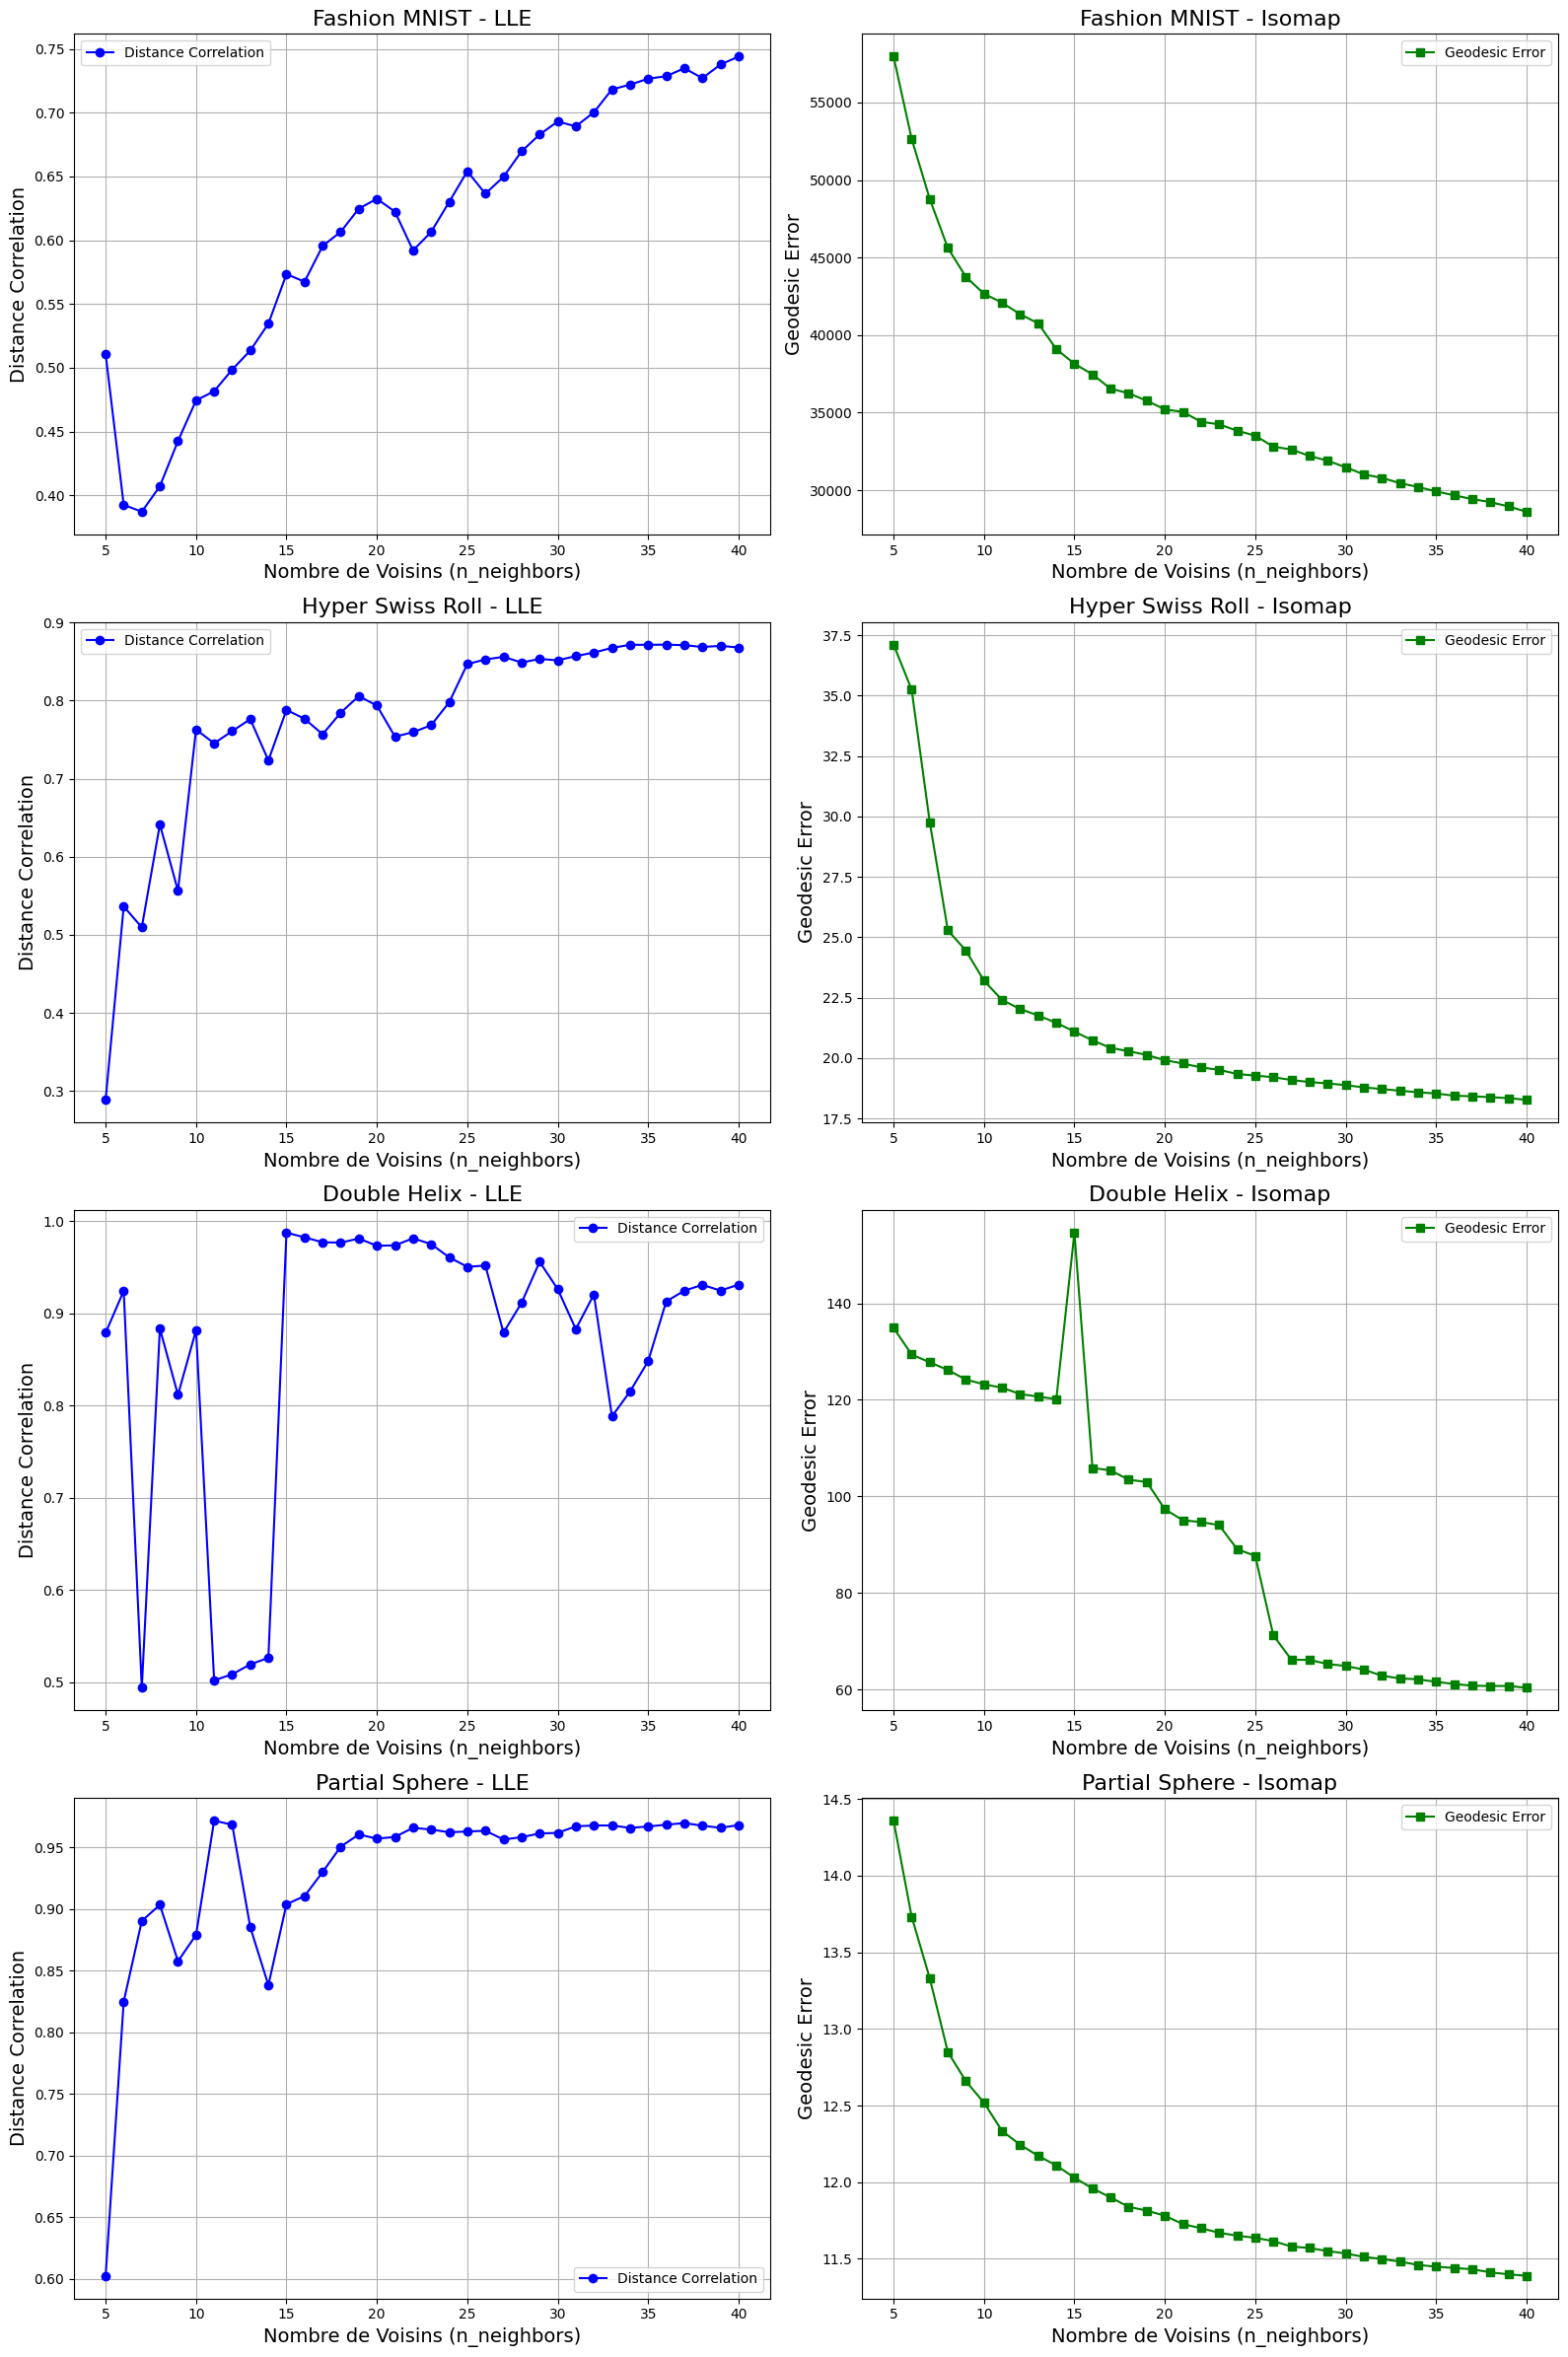

In [23]:
# Plot des résultats
plot_error_vs_n_neighbors(optimal_n_neighbors_results, n_neighbors_range)

On sélectionne les n_neighbors optimaux visuellement avec l'elbow méthode pour chaque dataset. 

In [5]:
n_neighbors_sphere = 12
n_neighbors_double_helix = 17
n_neighbors_swiss_roll = 13
n_neighbors_mnist = 17

optimal_n_neighbors = {'Double Helix': n_neighbors_double_helix, 'Fashion MNIST': n_neighbors_mnist, 'Hyper Swiss Roll': n_neighbors_swiss_roll, 'Partial Sphere': n_neighbors_sphere}

# Comparaison visuelle

Comparaison sur les données double helix:


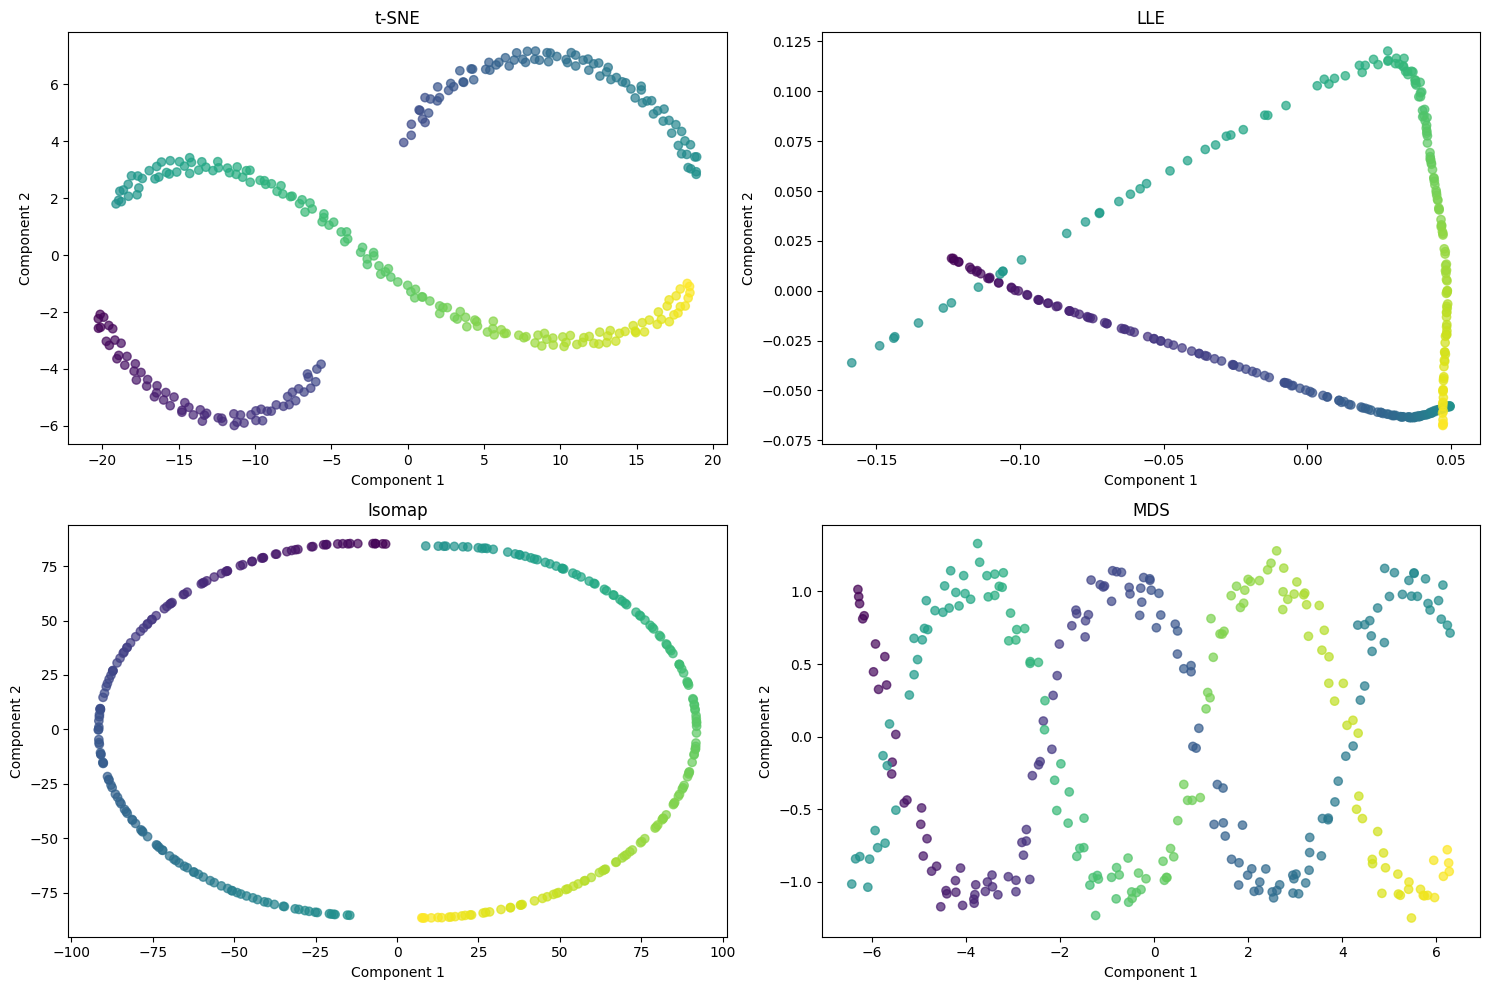

In [49]:
print("Comparaison sur les données double helix:")
plot_reducted_data(double_helix_data, double_helix_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=True, n_neighbors=n_neighbors_double_helix)

Comparaison sur les données Fashion-MNIST en 2D :


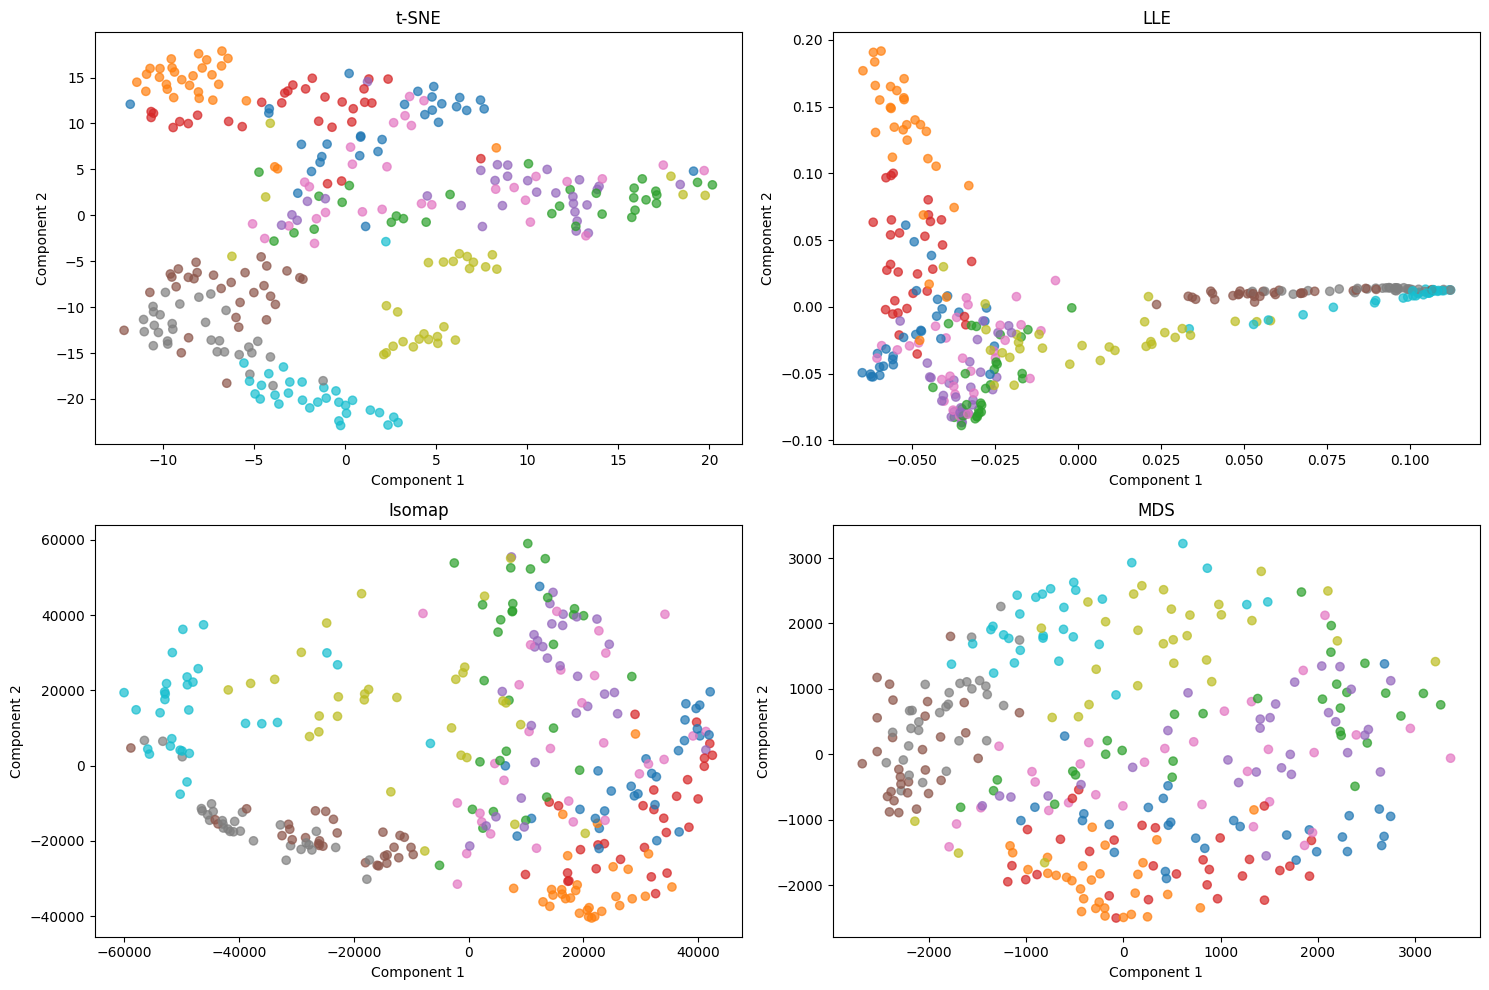

In [53]:
print("Comparaison sur les données Fashion-MNIST en 2D :")
plot_reducted_data(mnist_data, mnist_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=False, n_neighbors=n_neighbors_mnist)

Comparaison sur les données swiss roll :


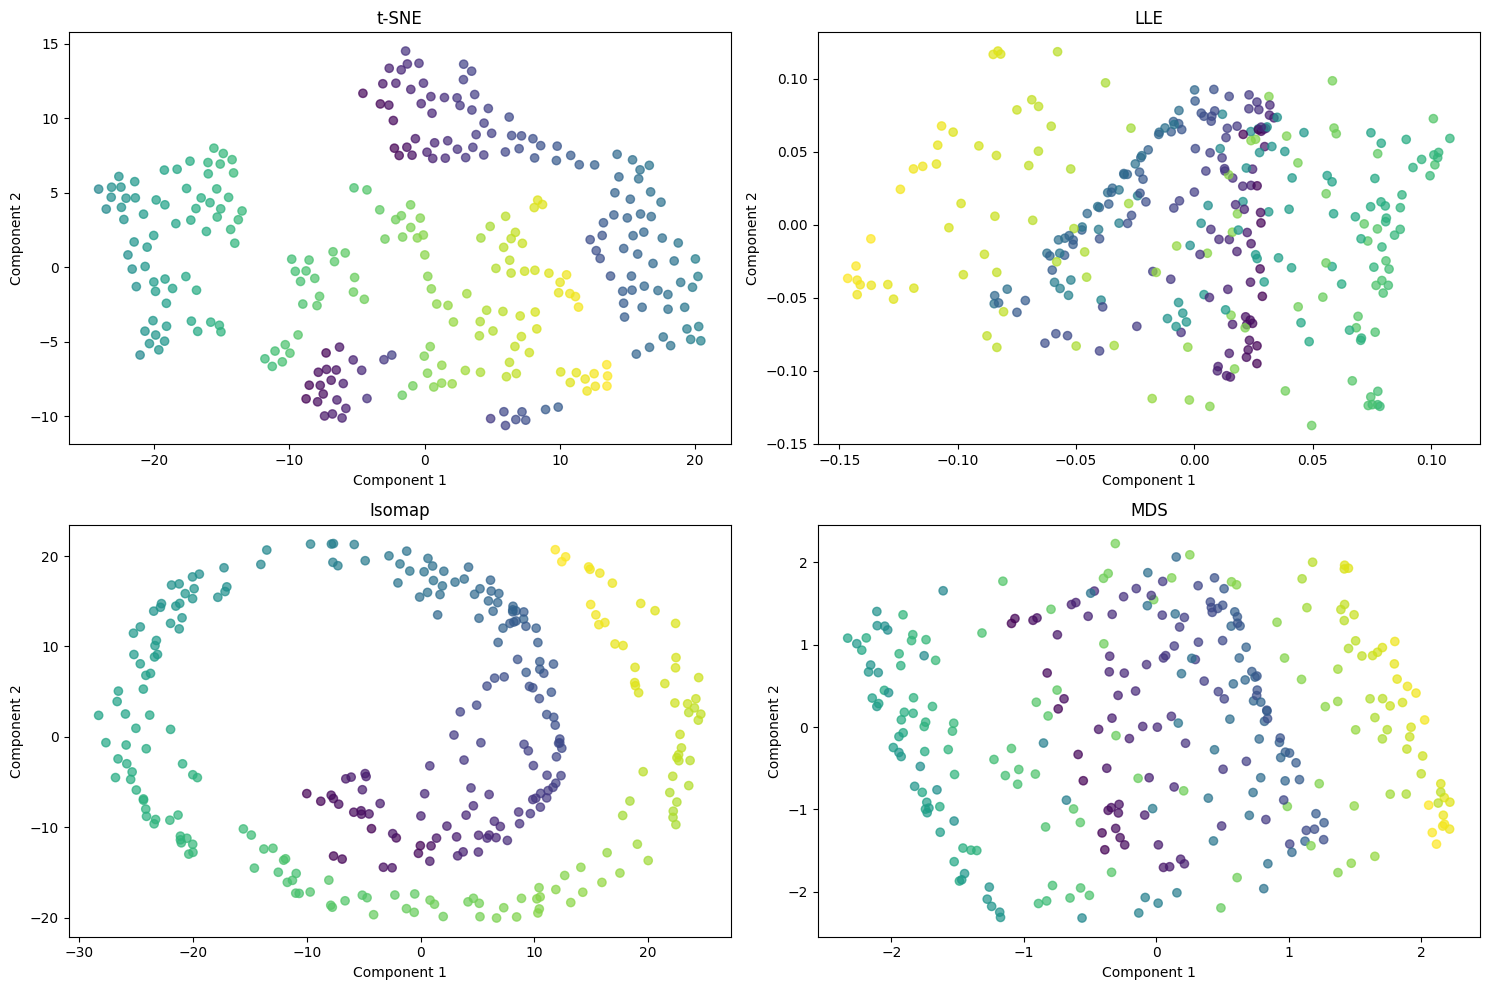

In [57]:
print("Comparaison sur les données swiss roll :")
plot_reducted_data(swiss_roll_data, swiss_roll_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=True, n_neighbors=n_neighbors_swiss_roll)

Comparaison sur les données spheres :


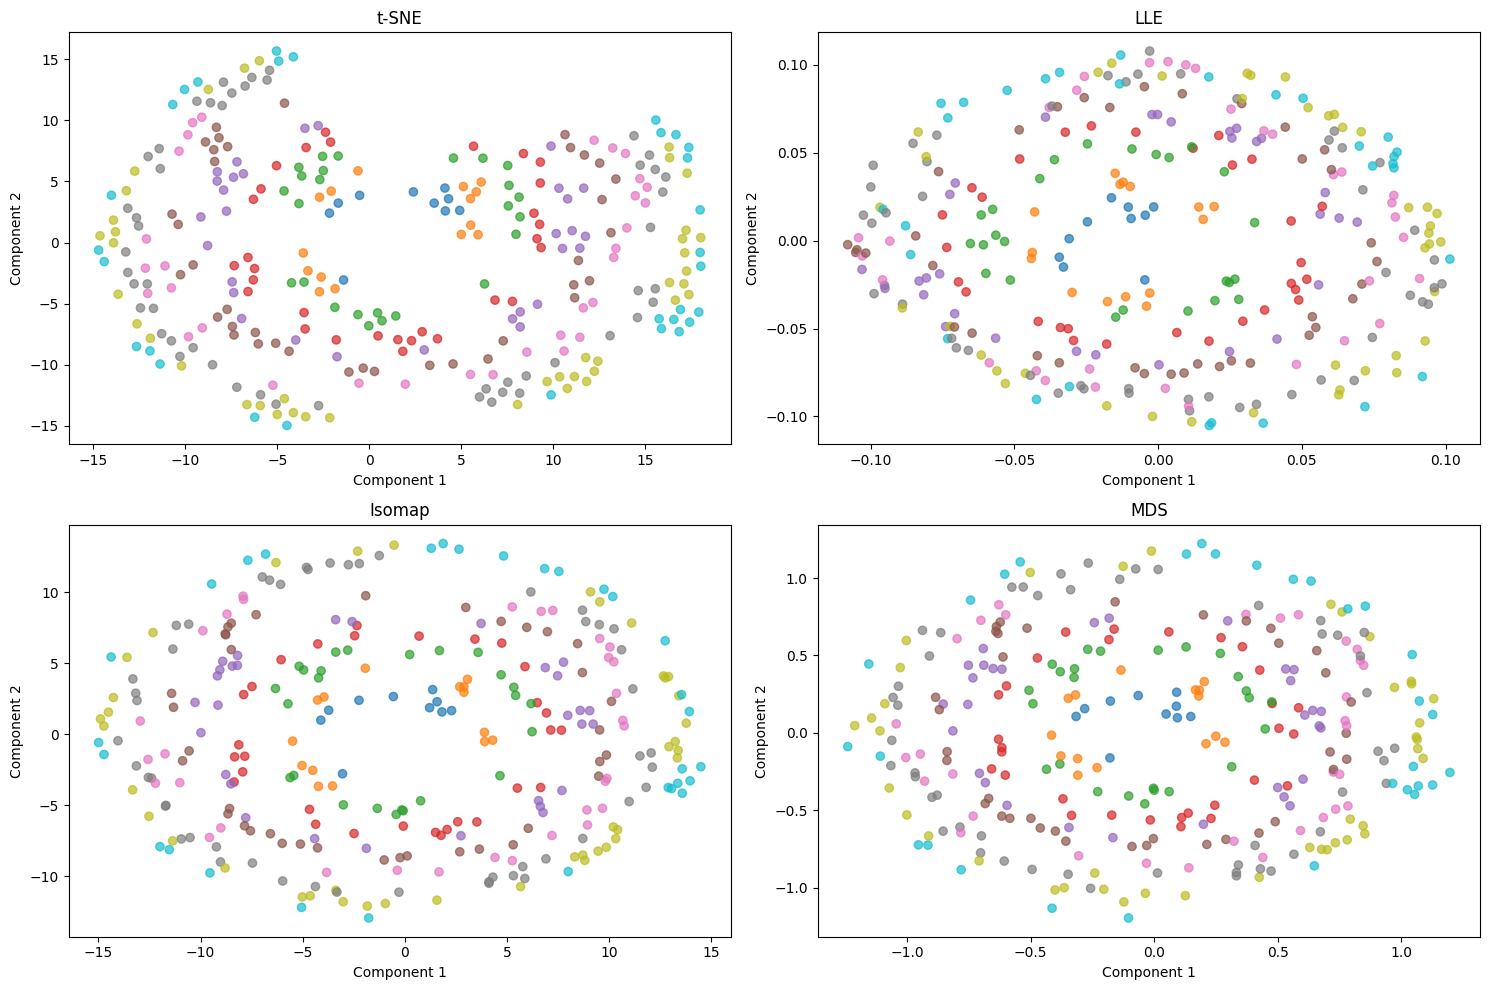

In [58]:
print("Comparaison sur les données spheres :")
plot_reducted_data(sphere_data, sphere_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=False, n_neighbors=n_neighbors_sphere)

| **Méthode** | **Jeu de données**       | **Points forts**                                                  | **Limitations des autres méthodes**                                                                                             |
|-------------|--------------------------|-------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| t-SNE       | MNIST                    | Clustering local efficace, visualisation des classes              | MDS ne préserve pas bien les structures locales, Isomap et LLE moins performants pour la séparation des clusters               |
| MDS         | Sphère 3D (Géométrique)  | Préservation des distances globales et de la géométrie globale    | t-SNE déforme les distances globales, Isomap et LLE ne sont pas optimisés pour les distances perçues                            |
| Isomap      | Swiss Roll               | Préservation des distances géodésiques, déroulage de la variété    | MDS échoue à capturer la structure non linéaire, t-SNE ne préserve pas les distances géodésiques, LLE moins efficace pour cette structure |
| LLE         | Double Helix             | Préservation des relations locales dans des structures enchevêtrées | MDS ne capture pas bien les relations locales, t-SNE peut ne pas séparer correctement les structures enchevêtrées, Isomap peut avoir des difficultés avec les distances géodésiques complexes |


# Comparaison numérique

In [15]:
# Comparaison numérique pour les données correctes

from IPython.display import display
from reduction_methods import apply_tsne, apply_lle, apply_mds, apply_isomap
from evaluator import evaluate_all_methods

method_names = ['t-SNE', 'LLE', 'MDS', 'Isomap' ]

# Evaluate and plot for each dataset
for dataset_name, (data, labels) in datasets.items():
    print(f"\nÉvaluation sur {dataset_name}:")
    
    # Prepare n_neighbors for the current dataset
    current_n_neighbors = optimal_n_neighbors[dataset_name]
    
    # Evaluate methods with dataset-specific n_neighbors
    results = evaluate_all_methods(
        X_original=data,
        method_names=method_names,
        labels=labels,
        n_neighbors=current_n_neighbors
    )
    
    display(results)


Évaluation sur Fashion MNIST:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.4275,0.4114,0.9506,0.9562,0.6527,0.8278,0.7649,0.6900,1.3950
LLE,0.6886,0.6716,0.9158,0.9290,0.4639,0.7861,0.5687,0.5567,0.0770
MDS,0.1494,0.1340,0.9783,0.9862,0.5743,0.9148,0.9299,0.5900,6.2154
Isomap,0.3202,0.3031,0.9607,0.9705,0.5620,0.8683,0.8332,0.6167,26.5221



Évaluation sur Hyper Swiss Roll:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.5872,0.5301,0.9473,0.9238,0.8244,0.8070,0.6823,0.7267,1.4610
LLE,0.4264,0.4472,0.9262,0.9588,0.4521,0.7777,0.7409,0.5767,0.0360
MDS,0.2288,0.2459,0.9571,0.9722,0.4825,0.8228,0.8671,0.6567,4.4420
Isomap,0.3689,0.3915,0.9385,0.9587,0.5124,0.8072,0.7779,0.9000,22.8630



Évaluation sur Double Helix:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.0609,0.0906,0.9878,0.9882,0.8705,0.9044,0.9531,0.9500,1.1030
LLE,0.5877,0.6001,0.9361,0.9051,0.8043,0.7659,0.6287,0.8767,0.0450
MDS,0.0072,0.0161,0.9966,0.9975,0.7764,0.9456,0.9919,0.8067,4.3790
Isomap,0.6427,0.7116,0.9285,0.8896,0.8939,0.7608,0.5324,0.9733,18.6710



Évaluation sur Partial Sphere:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.0926,0.0887,0.9922,0.9876,0.8201,0.9260,0.9542,0.4733,1.1090
LLE,0.0669,0.0645,0.9912,0.9939,0.7090,0.9240,0.9669,0.4500,0.0340
MDS,0.0299,0.0250,0.9970,0.9976,0.7814,0.9488,0.9873,0.5133,2.4940
Isomap,0.0418,0.0372,0.9954,0.9959,0.7966,0.9375,0.9810,0.4933,18.8960


🟢 Métrique adaptée.
🟠 Métrique peu adaptée.
🔴 Métrique non adaptée.

**Classification Metric**
Pour évaluer la qualité des méthodes de réduction de dimension, on utilise une métrique de classification basée sur la capacité d'un classifieur SVC avec noyau Gaussien, à classifier les données réduites. 

**Évaluation de la Métrique pour Chaque Méthode de Réduction de Dimension**

**MDS (Métrique, Global) :**
MDS minimise le stress global, préservant les distances euclidiennes sur l’ensemble du dataset. Les métriques globales, comme la corrélation de distances ou le Kruskal Stress (Residual Pearson/Spearman), sont favorables à MDS (🟢). Cependant, les métriques locales (Trustworthiness, Continuity, Qlocal) sont moins adaptées (🟠), car MDS ne cherche pas à préserver les relations locales. La métrique de classification est peu adaptée pour MDS, reflétant la faiblesse de la méthode à préserver les informations locales nécessaires à une bonne discrimination des classes. (🔴)

**Isomap (Métrique, Local et Global) :**
Isomap utilise des graphes de voisinage pour capturer la structure locale (via des distances géodésiques) et applique ensuite une méthode similaire à MDS sur ces distances. Ainsi, il préserve à la fois des aspects locaux et globaux, mais pas forcément aussi bien que MDS pour le global ou LLE/t-SNE pour le local. Certains indicateurs locaux (Qlocal, Qglobal, Distance Correlation) sont verts, tandis que la fiabilité du voisinage local n’est pas parfaitement conservée par rapport à t-SNE ou LLE (🟠 pour Trustworthiness, Continuity). La métrique de classification est modérément adaptée pour Isomap, reflétant sa capacité à préserver à la fois les structures locales et globales, mais avec des compromis sur la complexité des frontières décisionnelles. (🟠)

**LLE (Topologique, Local) :**
LLE est purement local, se concentrant sur la conservation des relations de voisinage. Par conséquent, les métriques locales (Trustworthiness, Continuity, Qlocal) sont vertes (🟢), tandis que les métriques globales ou basées sur la distance (Residual Pearson, Spearman, Distance Correlation) sont inadaptées (🔴 ou 🟠). La métrique de classification est bien adaptée pour LLE, reflétant sa forte préservation des structures locales essentielles pour une discrimination efficace des classes. (🟢)

**t-SNE (Topologique, Local) :**
t-SNE est très bon pour préserver la structure locale et visualiser des clusters, donc tout ce qui évalue la fiabilité du voisinage local (Trustworthiness, Continuity, Qlocal) est vert (🟢), et la classification est souvent efficace. En revanche, les métriques globales (Residual Pearson, Spearman) ne sont pas pertinentes, car t-SNE déforme les distances globales. La métrique de classification est bien adaptée pour t-SNE, en raison de sa capacité à maintenir les structures locales essentielles pour une discrimination efficace des classes. (🟢)

# Jeu de données réel

Number of samples: 713
Shape of X: (713, 100)


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.8056,0.8111,0.8413,0.8621,0.3610,0.6241,0.4322,0.7139,4.0531
LLE,0.9445,0.7178,0.8321,0.8390,0.3752,0.8556,0.5292,0.5596,0.1440
MDS,0.6738,0.6772,0.8467,0.8880,0.3014,0.7696,0.5663,0.6592,106.0670
Isomap,0.8386,0.8435,0.8090,0.8127,0.3827,0.8699,0.3931,0.5863,868.8123


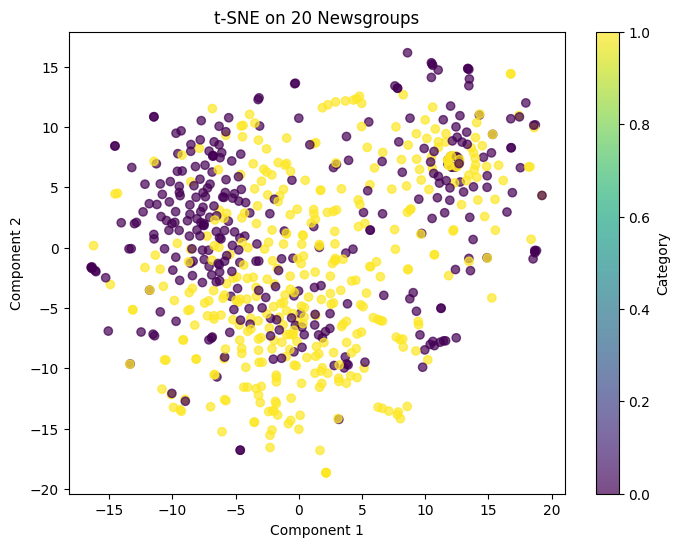

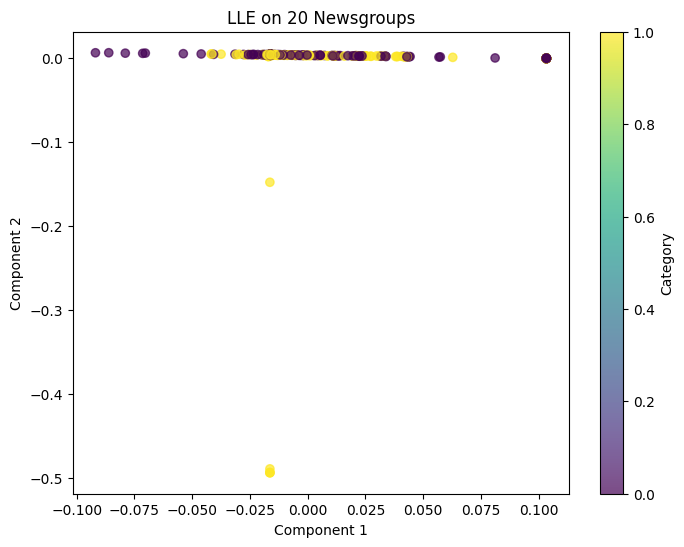

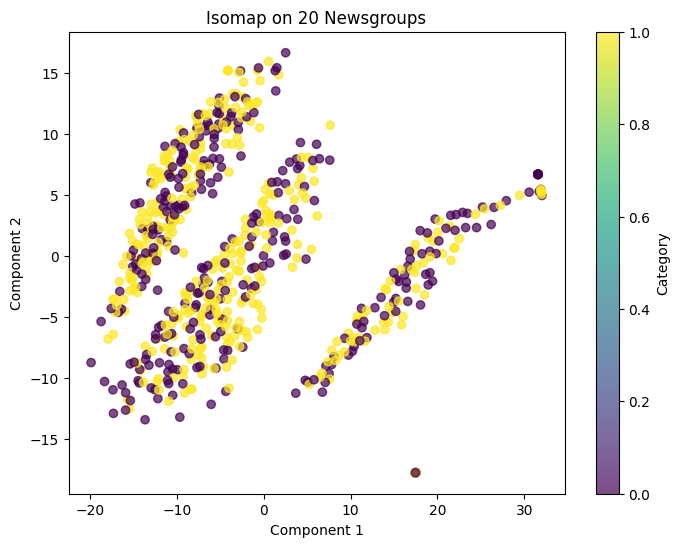

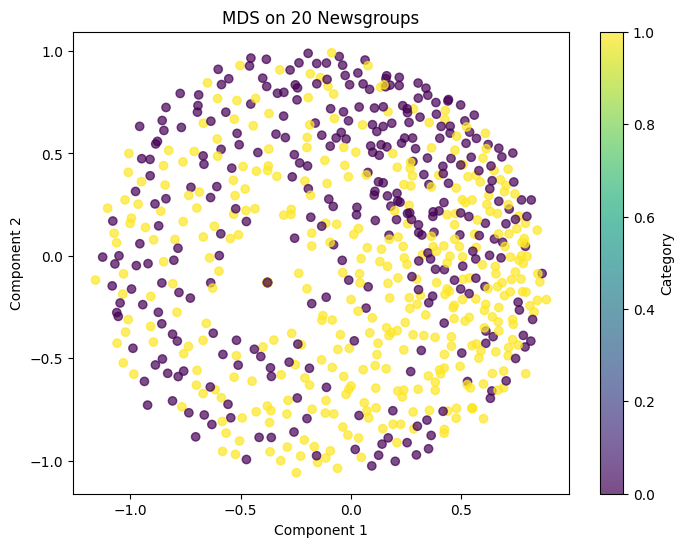

In [16]:
# !!! Ne pas compiler ça dure 1h30.
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from evaluator import evaluate_all_methods
from reduction_methods import apply_tsne, apply_lle, apply_isomap, apply_mds
from IPython.display import display

# Load the 20 Newsgroups dataset
categories = ['alt.atheism', 'sci.space']  # Specify categories of interest
newsgroups = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)
print(f"Number of samples: {len(newsgroups.data)}")

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(newsgroups.data).toarray()
y = newsgroups.target
print(f"Shape of X: {X.shape}")

# Define the dimensionality reduction methods to evaluate
method_names = ['t-SNE', 'LLE', 'MDS', 'Isomap']

# Evaluate all methods using the evaluator
results = evaluate_all_methods(
    X_original=X,
    method_names=method_names,
    labels=y,
    n_neighbors= 15
)

# Display the evaluation results
display(results)

# Function to plot the reduced embeddings
def plot_embedding(X_reduced, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=y,
        cmap='viridis',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label='Category')
    plt.show()

# Apply dimensionality reduction methods and plot their embeddings
X_tsne = apply_tsne(X, n_components=2)
plot_embedding(X_tsne, "t-SNE on 20 Newsgroups")

X_lle = apply_lle(X, n_components=2, n_neighbors=17)
plot_embedding(X_lle, "LLE on 20 Newsgroups")

X_isomap = apply_isomap(X, n_components=2, n_neighbors=13)
plot_embedding(X_isomap, "Isomap on 20 Newsgroups")

X_mds = apply_mds(X, n_components=2)
plot_embedding(X_mds, "MDS on 20 Newsgroups")